## Primjeri

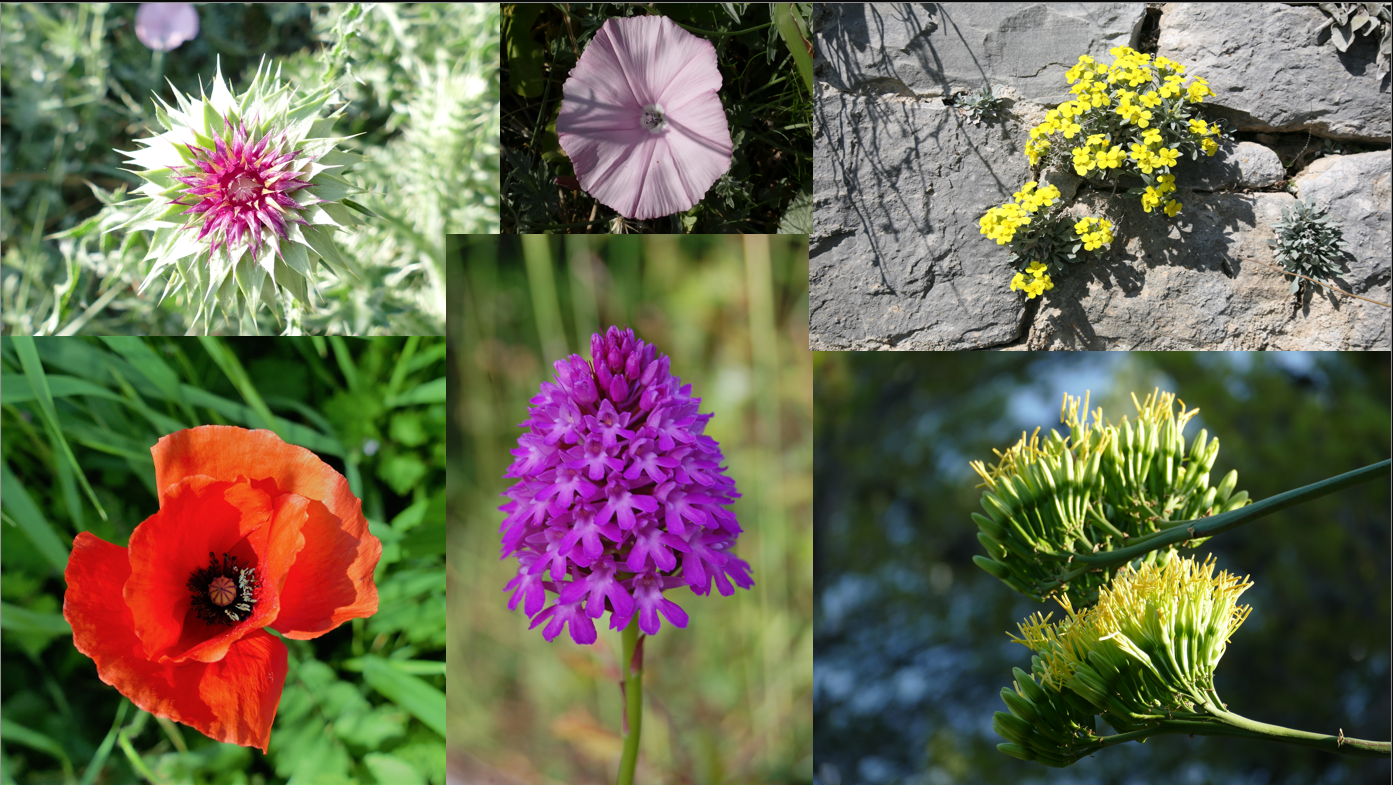

## Skup podataka

In [ ]:
pip install split-folders

In [ ]:
import splitfolders

In [ ]:
import glob
import os

In [ ]:
number_of_images = {}
for file in os.listdir(r'/content/drive/MyDrive/cvice'):
  count = 0
  for image in os.listdir(r'/content/drive/MyDrive/cvice'+'/'+file):
    count = count+1
    number_of_images[file] = count

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


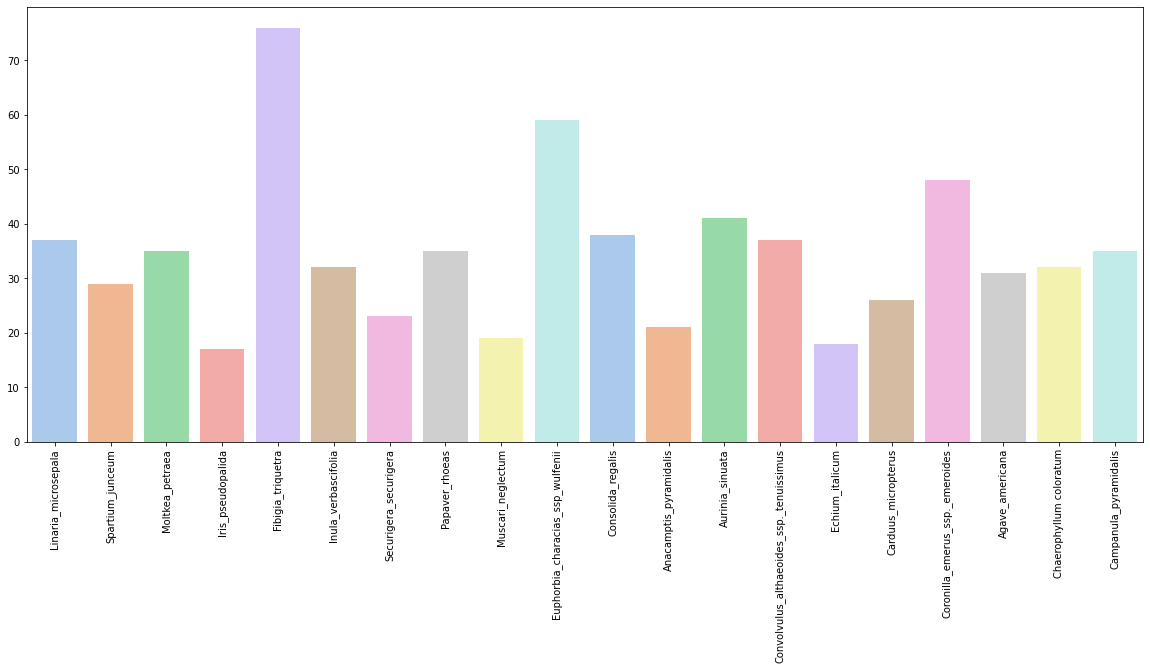

In [ ]:
plt.figure(figsize=(20,8))
ind = np.arange(len(number_of_images))
#cmapsns.light_palette("seagreen", as_cmap=True)
sns.barplot(ind, list(number_of_images.values()),palette = "pastel")
plt.xticks(ind, list(number_of_images.keys()),rotation=90)
plt.show()


## Odabir modela

In [ ]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.resnet import ResNet101
from keras.layers import Dense
from keras.models import Model, Sequential

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
new_model_dict = {key: model_dictionary[key] for key in model_dictionary  if key not in ['EfficientNetB2','EfficientNetB3','EfficientNetB4','EfficientNetB5','EfficientNetB6', 'EfficientNetB7','EfficientNetV2B0','EfficientNetV2B1','EfficientNetV2B2','EfficientNetV2B3','EfficientNetV2L','EfficientNetV2M','EfficientNetV2S','MobileNetV3Large','MobileNetV3Small','NASNetMobile']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/cvice', output="output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 689 files [06:01,  1.90 files/s]


In [ ]:
from keras.preprocessing import image

In [ ]:
def preprocess_data(batch_size, img_size):
  #train_gen = image.ImageDataGenerator(rescale = 1./255.)
  train_gen = image.ImageDataGenerator(rescale = 1./255.,
                                     )
  train_generator = train_gen.flow_from_directory(
                                      "/content/output/train",
                                      target_size = img_size,
                                      class_mode = "categorical",
                                      shuffle = True,
                                      batch_size = batch_size
                                      )
  val_datagen = image.ImageDataGenerator(rescale = 1./255.)
  val_generator = val_datagen.flow_from_directory("/content/output/val",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle = False)
  test_datagen = image.ImageDataGenerator(rescale = 1./255.)
  test_generator = test_datagen.flow_from_directory("/content/output/test",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle= False)
  return train_generator,val_generator,test_generator

In [ ]:
# Run preprocessing
train_processed_224, validation_processed_224, test_processed_224 = preprocess_data(batch_size, img_size=[224,224])
train_processed_331, validation_processed_331, test_processed_331 = preprocess_data(batch_size, img_size=[331,331])
train_processed_299, validation_processed_299, test_processed_299 = preprocess_data(batch_size, img_size=[299,299])

Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.
Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.
Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.


In [ ]:
# Number of training examples and labels
num_train =train_processed_224.samples
num_validation =  validation_processed_224.samples
num_classes = len(list( validation_processed_224.class_indices.keys()))
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 472         
Num validation images: 93         
Num classes: 20         
Num iterations per epoch: 14


In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': [], 'test_accuracy': []}
for model_name, model in tqdm(list(new_model_dict.items())[:5]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
        test_processed = test_processed_331
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/5 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 200s 14s/step - loss: 2.8200 - accuracy: 0.1705 - val_loss: 2.4091 - val_accuracy: 0.2903
Epoch 2/3
14/14 [==============================] - 179s 13s/step - loss: 2.2145 - accuracy: 0.4000 - val_loss: 2.0590 - val_accuracy: 0.4516
Epoch 3/3
4/4 [==============================] - 42s 10s/step - loss: 1.8461 - accuracy: 0.5565


 20%|██        | 1/5 [10:49<43:18, 649.63s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 205s 14s/step - loss: 2.7008 - accuracy: 0.2000 - val_loss: 2.2449 - val_accuracy: 0.3226
Epoch 2/3
14/14 [==============================] - 193s 14s/step - loss: 1.9190 - accuracy: 0.5023 - val_loss: 1.7765 - val_accuracy: 0.6344
Epoch 3/3
4/4 [==============================] - 42s 9s/step - loss: 1.5112 - accuracy: 0.6532


 40%|████      | 2/5 [22:50<34:34, 691.40s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 237s 16s/step - loss: 2.6024 - accuracy: 0.2864 - val_loss: 2.1045 - val_accuracy: 0.5376
Epoch 2/3
14/14 [==============================] - 220s 15s/step - loss: 1.8485 - accuracy: 0.5750 - val_loss: 1.6937 - val_accuracy: 0.6559
Epoch 3/3
4/4 [==============================] - 50s 11s/step - loss: 1.5258 - accuracy: 0.6855


 60%|██████    | 3/5 [35:53<24:26, 733.25s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 155s 11s/step - loss: 2.9924 - accuracy: 0.0750 - val_loss: 2.9118 - val_accuracy: 0.0860
Epoch 2/3
14/14 [==============================] - 137s 10s/step - loss: 2.9507 - accuracy: 0.0773 - val_loss: 2.9085 - val_accuracy: 0.1183
Epoch 3/3
4/4 [==============================] - 30s 7s/step - loss: 2.9557 - accuracy: 0.0968


 80%|████████  | 4/5 [45:02<11:00, 660.74s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 171s 12s/step - loss: 3.0099 - accuracy: 0.0750 - val_loss: 2.9251 - val_accuracy: 0.1183
Epoch 2/3
14/14 [==============================] - 150s 11s/step - loss: 2.9815 - accuracy: 0.0841 - val_loss: 2.9178 - val_accuracy: 0.1183
Epoch 3/3
4/4 [==============================] - 32s 7s/step - loss: 2.9716 - accuracy: 0.0968


100%|██████████| 5/5 [55:21<00:00, 664.30s/it]


In [ ]:
for model_name, model in tqdm(list(new_model_dict.items())[5:10]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
        test_processed = test_processed_331
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/5 [00:00<?, ?it/s]

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/3
14/14 [==============================] - 325s 22s/step - loss: 2.6976 - accuracy: 0.2386 - val_loss: 2.2099 - val_accuracy: 0.3763
Epoch 2/3
14/14 [==============================] - 255s 18s/step - loss: 1.9500 - accuracy: 0.5295 - val_loss: 1.7928 - val_accuracy: 0.5914
Epoch 3/3
4/4 [==============================] - 59s 12s/step - loss: 1.6494 - accuracy: 0.5645


 20%|██        | 1/5 [15:35<1:02:23, 935.83s/it]

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 199s 14s/step - loss: 2.8367 - accuracy: 0.1909 - val_loss: 2.1210 - val_accuracy: 0.4301
Epoch 2/3
14/14 [==============================] - 175s 12s/step - loss: 1.8277 - accuracy: 0.5500 - val_loss: 1.7127 - val_accuracy: 0.6129
Epoch 3/3
4/4 [==============================] - 38s 9s/step - loss: 1.4839 - accuracy: 0.6532


 40%|████      | 2/5 [26:16<38:06, 762.31s/it]  WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 158s 11s/step - loss: 2.8371 - accuracy: 0.1795 - val_loss: 2.1689 - val_accuracy: 0.3656
Epoch 2/3
14/14 [==============================] - 145s 11s/step - loss: 1.9178 - accuracy: 0.5159 - val_loss: 1.6602 - val_accuracy: 0.5806
Epoch 3/3
4/4 [==============================] - 31s 8s/step - loss: 1.4837 - accuracy: 0.6532


 60%|██████    | 3/5 [36:21<23:00, 690.26s/it]WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 157s 11s/step - loss: 2.6994 - accuracy: 0.2295 - val_loss: 2.1978 - val_accuracy: 0.3656
Epoch 2/3
14/14 [==============================] - 127s 9s/step - loss: 1.8601 - accuracy: 0.5500 - val_loss: 1.7614 - val_accuracy: 0.6344
Epoch 3/3
4/4 [==============================] - 28s 7s/step - loss: 1.5268 - accuracy: 0.6613


 80%|████████  | 4/5 [45:20<10:30, 630.70s/it]

343621632/343610240 [==============================] - 3s 0us/step
Epoch 1/3
14/14 [==============================] - 521s 36s/step - loss: 2.3123 - accuracy: 0.3545 - val_loss: 1.6076 - val_accuracy: 0.6559
Epoch 2/3
14/14 [==============================] - 541s 39s/step - loss: 1.2312 - accuracy: 0.7750 - val_loss: 1.2132 - val_accuracy: 0.7527
Epoch 3/3
4/4 [==============================] - 113s 26s/step - loss: 1.1594 - accuracy: 0.6774


100%|██████████| 5/5 [1:16:23<00:00, 916.72s/it] 


In [ ]:
for model_name, model in tqdm(list(new_model_dict.items())[10:15]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
        test_processed = test_processed_331
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/5 [00:00<?, ?it/s]

171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 286s 20s/step - loss: 3.1774 - accuracy: 0.0591 - val_loss: 3.0215 - val_accuracy: 0.1183
Epoch 2/3
14/14 [==============================] - 282s 20s/step - loss: 2.9896 - accuracy: 0.1027 - val_loss: 2.9336 - val_accuracy: 0.0753
Epoch 3/3
4/4 [==============================] - 62s 14s/step - loss: 3.0048 - accuracy: 0.0968


 20%|██        | 1/5 [16:20<1:05:21, 980.34s/it]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 275s 19s/step - loss: 2.4705 - accuracy: 0.2841 - val_loss: 1.7835 - val_accuracy: 0.6129
Epoch 2/3
14/14 [==============================] - 252s 18s/step - loss: 1.3162 - accuracy: 0.7455 - val_loss: 1.2547 - val_accuracy: 0.7419
Epoch 3/3
4/4 [==============================] - 59s 13s/step - loss: 1.1139 - accuracy: 0.7419


 40%|████      | 2/5 [32:24<48:31, 970.61s/it]  

234708992/234698864 [==============================] - 2s 0us/step
Epoch 1/3
14/14 [==============================] - 411s 29s/step - loss: 3.2531 - accuracy: 0.0826 - val_loss: 3.0451 - val_accuracy: 0.0430
Epoch 2/3
14/14 [==============================] - 364s 26s/step - loss: 3.0480 - accuracy: 0.0705 - val_loss: 2.9870 - val_accuracy: 0.1075
Epoch 3/3
4/4 [==============================] - 83s 19s/step - loss: 3.0086 - accuracy: 0.1129


 60%|██████    | 3/5 [56:21<39:27, 1183.58s/it]

234561536/234545216 [==============================] - 2s 0us/step
Epoch 1/3
14/14 [==============================] - 388s 27s/step - loss: 2.4840 - accuracy: 0.2727 - val_loss: 1.7961 - val_accuracy: 0.5806
Epoch 2/3
14/14 [==============================] - 353s 25s/step - loss: 1.4174 - accuracy: 0.6864 - val_loss: 1.3437 - val_accuracy: 0.7204
Epoch 3/3
4/4 [==============================] - 86s 18s/step - loss: 1.1994 - accuracy: 0.7500


 80%|████████  | 4/5 [1:17:49<20:25, 1225.12s/it]

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 216s 15s/step - loss: 3.1534 - accuracy: 0.0886 - val_loss: 3.0261 - val_accuracy: 0.0753
Epoch 2/3
14/14 [==============================] - 216s 15s/step - loss: 2.9821 - accuracy: 0.1023 - val_loss: 2.9350 - val_accuracy: 0.1075
Epoch 3/3
4/4 [==============================] - 43s 9s/step - loss: 2.9354 - accuracy: 0.1129


100%|██████████| 5/5 [1:31:57<00:00, 1103.42s/it]


In [ ]:
for model_name, model in tqdm(list(new_model_dict.items())[15:]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
        test_processed = test_processed_331
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/4 [00:00<?, ?it/s]

94683136/94668760 [==============================] - 3s 0us/step
Epoch 1/3
14/14 [==============================] - 197s 14s/step - loss: 2.5145 - accuracy: 0.2795 - val_loss: 1.8470 - val_accuracy: 0.5376
Epoch 2/3
14/14 [==============================] - 199s 14s/step - loss: 1.4735 - accuracy: 0.6705 - val_loss: 1.3635 - val_accuracy: 0.7312
Epoch 3/3
4/4 [==============================] - 41s 9s/step - loss: 1.2172 - accuracy: 0.7339


 25%|██▌       | 1/4 [11:14<33:43, 674.44s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
14/14 [==============================] - 418s 30s/step - loss: 2.9961 - accuracy: 0.1091 - val_loss: 2.8548 - val_accuracy: 0.1505
Epoch 2/3
14/14 [==============================] - 423s 30s/step - loss: 2.8503 - accuracy: 0.1636 - val_loss: 2.7775 - val_accuracy: 0.1828
Epoch 3/3
4/4 [==============================] - 95s 21s/step - loss: 2.7753 - accuracy: 0.1694


 50%|█████     | 2/4 [34:19<36:25, 1092.62s/it]

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 667s 49s/step - loss: 3.0583 - accuracy: 0.1136 - val_loss: 2.8728 - val_accuracy: 0.1290
Epoch 2/3
14/14 [==============================] - 552s 40s/step - loss: 2.8767 - accuracy: 0.1182 - val_loss: 2.7984 - val_accuracy: 0.1398
Epoch 3/3
4/4 [==============================] - 119s 28s/step - loss: 2.7924 - accuracy: 0.1532


 75%|███████▌  | 3/4 [1:07:02<24:50, 1490.04s/it]

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/3
14/14 [==============================] - 276s 19s/step - loss: 2.5665 - accuracy: 0.2659 - val_loss: 2.0905 - val_accuracy: 0.4624
Epoch 2/3
14/14 [==============================] - 231s 17s/step - loss: 1.8722 - accuracy: 0.6341 - val_loss: 1.6741 - val_accuracy: 0.7312
Epoch 3/3
4/4 [==============================] - 48s 11s/step - loss: 1.5037 - accuracy: 0.7016


100%|██████████| 4/4 [1:22:58<00:00, 1244.67s/it]


In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy,test_accuracy
8,MobileNetV2,2257984,0.741935,0.661290
7,MobileNet,3228864,0.731183,0.653226
3,EfficientNetB0,4049571,0.118280,0.096774
4,EfficientNetB1,6575239,0.118280,0.096774
0,DenseNet121,7037504,0.591398,0.556452
1,DenseNet169,12642880,0.645161,0.653226
16,VGG16,14714688,0.215054,0.169355
2,DenseNet201,18321984,0.741935,0.685484
17,VGG19,20024384,0.182796,0.153226
18,Xception,20861480,0.784946,0.701613


In [ ]:
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]

In [ ]:
len(markers)

33

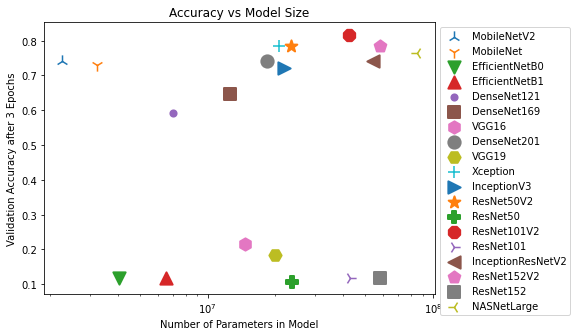

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

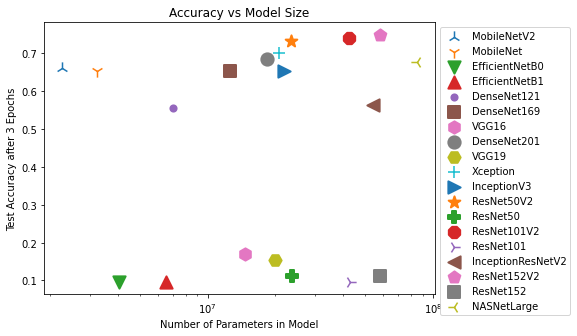

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.test_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Test Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot